In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import html
import re
import string
from fncbaseline.utils import dataset, generate_test_splits, score
from nltk.corpus import stopwords
from gensim.summarization import summarize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from fncbaseline.utils import dataset, generate_test_splits, score
from fncbaseline import feature_engineering
from nltk.corpus import stopwords
from gensim.summarization import summarize

from nltk.corpus import stopwords
import html
import re
from nltk import sent_tokenize
import nltk.data
from nltk.tokenize import word_tokenize

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')


/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load the dataset
train_dataset = dataset.DataSet()
test_dataset = dataset.DataSet('test')

Reading dataset
Total stances: 49972
Total bodies: 1683
Reading dataset
Total stances: 25413
Total bodies: 904


In [3]:
def preprocess(text):
    text = html.unescape(text)
    text = text.replace("\\n"," ")
    #text = text.replace("\"","")
    text = text.replace("_NEG","")
    text = text.replace("_NEGFIRST", "")
    #text = re.sub(r"#", "", text)
    text = re.sub(r"\*", "", text)
    #text = re.sub(r"\'s", "", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    #text = re.sub(r",", "", text)
    #text = re.sub(r"!", " !", text)
    #text = re.sub(r"\(", "", text)
    #text = re.sub(r"\)", "", text)
    #text = re.sub(r"\?", " ?", text)
    #text = re.sub(r'[^\x00-\x7F]',' ', text)
    #text = re.sub(r'[^\w\s]',' ',text)
    #text = re.sub("\d+", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    #text = text.rstrip(',|.|;|:|\'|\"')
    #text = text.strip('\'|\"|" "')
    #text=text.lstrip('" "')
    text=text.replace('..', '. ')
    text=text.replace('--', '. ')
    text = text.replace('\n','. ')

    return text

In [6]:
head_data=dict()
for s in test_dataset.stances:
    if s['Headline'] not in head_data:
        text=s['Headline']
        text=text.replace('”', '')
        text=text.replace('“', '')
        text=text.replace('"', '')
        text=preprocess(text)
        head_data[s['Headline']] = text

for s in train_dataset.stances:
    if s['Headline'] not in head_data:
        a=list()
        text=s['Headline']
        text=text.replace('”', '')
        text=text.replace('“', '')
        text=text.replace('"', '')
        head_data[s['Headline']] = text

In [11]:
len(head_data)

2532

In [13]:
# Returns (3,num_words,1024)

from allennlp.commands.elmo import ElmoEmbedder
from allennlp.modules.elmo import Elmo, batch_to_ids

options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"
elmo = ElmoEmbedder(options_file, weight_file)


/home/shared/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [15]:
elmo_head = dict()
counter = 0
for headline in head_data:
    embeddings = elmo.embed_sentences(head_data[headline])
    emb = next(embeddings)
    emb = np.mean(np.mean(emb,axis = 0),axis = 0)
    elmo_head[headline] = emb
    if counter%200 ==0:
        print (counter)
    counter+=1

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400


In [17]:
np.save('elmo_head.npy',elmo_head)

In [18]:
elmo_body = np.load('elmo_body.npy').item()

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

In [78]:
# Create the train and test dataset:
X_train_head = list()
X_train_body = list()
y_train = list()

category_dict = {'unrelated': 0 , 'agree':1, 'disagree':2, 'discuss':3}
for s in train_dataset.stances:
    head_emb = elmo_head[s['Headline']].reshape((1,1024))
    body_emb = elmo_body[s['Body ID']].reshape((1,1024))
    #print(head_emb.shape, body_emb.shape,cosine_similarity(head_emb,body_emb).shape)
    X_train_head.append(head_emb)
    X_train_body.append(body_emb)
    y_train.append(category_dict[s['Stance']])
    
    

In [79]:
X_test_head = list()
X_test_body = list()
y_test = list()

category_dict = {'unrelated': 0 , 'agree':1, 'disagree':2, 'discuss':3}
for s in test_dataset.stances:
    head_emb = elmo_head[s['Headline']].reshape((1,1024))
    body_emb = elmo_body[s['Body ID']].reshape((1,1024))
    #print(head_emb.shape, body_emb.shape,cosine_similarity(head_emb,body_emb).shape)
    X_test_head.append(head_emb)
    X_test_body.append(body_emb)
    y_test.append(category_dict[s['Stance']])

In [80]:
X_train_head = np.squeeze(np.asarray(X_train_head))
X_train_body = np.squeeze(np.asarray(X_train_body))

X_test_head = np.squeeze(np.asarray(X_test_head))
X_test_body = np.squeeze(np.asarray(X_test_body))
print(X_train_body.shape,X_train_head.shape,X_test_head.shape,X_test_body.shape)

(49972, 1024) (49972, 1024) (25413, 1024) (25413, 1024)


In [81]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print
    

<function print>

In [82]:
# Keras Import Statements
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Embedding, Input, Lambda
from keras.layers.wrappers import Bidirectional
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import SGD, Adagrad
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import LSTM, GRU
from keras.layers import concatenate,dot,add,subtract,multiply
from keras.preprocessing import sequence
import keras.backend as K
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
head_input (InputLayer)         (None, 1024)         0                                            
__________________________________________________________________________________________________
body_input (InputLayer)         (None, 1024)         0                                            
__________________________________________________________________________________________________
subtract_4 (Subtract)           (None, 1024)         0           head_input[0][0]                 
                                                                 body_input[0][0]                 
__________________________________________________________________________________________________
multiply_3 (Multiply)           (None, 1024)         0           head_input[0][0]                 
          

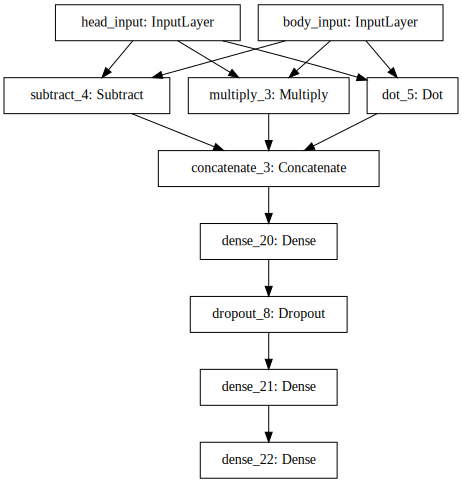

In [83]:
head_input = Input(shape=(X_train_head.shape[1],), name='head_input')
body_input = Input(shape=(X_train_body.shape[1],), name='body_input')

dot_layer = dot([head_input,body_input],axes = 1,normalize=True)
sub_layer = subtract([head_input,body_input])
prod_layer = multiply([head_input,body_input])
conc = concatenate([sub_layer,prod_layer,dot_layer])
dense = Dense(1000,activation='relu')(conc)
dense = Dropout(0.3)(dense)
dense = Dense(50,activation='relu')(dense)
dense = Dense(4,activation='softmax')(dense)
model = Model(inputs=[head_input,body_input], outputs=[dense])
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])
print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [84]:
def evaluate_answer(model,model_inp, true):
    inv_category_dict = {0:'unrelated', 1: 'agree', 2: 'disagree', 3: 'discuss'}
    predicted = model.predict(model_inp)
    predicted = np.argmax(predicted,axis = 1)
    t = np.argmax(true,axis = 1)
    ground = list()
    pred = list()
    for i in predicted:
        pred.append(inv_category_dict[i])
    for i in t:
        ground.append(inv_category_dict[i])
    score.report_score(ground, pred)

In [ ]:
for i in range(10):
    model.fit([X_train_head,X_train_body],y_train, epochs=20, batch_size=128,verbose = True)
    evaluate_answer(model,[X_test_head,X_test_body],y_test)

Epoch 1/20
49972/49972 [==============================] - 14s 274us/step - loss: 0.8057 - acc: 0.7296
Epoch 2/20
49972/49972 [==============================] - 13s 251us/step - loss: 0.7883 - acc: 0.7313
Epoch 3/20
49972/49972 [==============================] - 13s 253us/step - loss: 0.7850 - acc: 0.7313
Epoch 4/20
49972/49972 [==============================] - 13s 255us/step - loss: 0.7830 - acc: 0.7313
Epoch 5/20
49972/49972 [==============================] - 13s 255us/step - loss: 0.7789 - acc: 0.7318
Epoch 6/20
49972/49972 [==============================] - 13s 259us/step - loss: 0.7758 - acc: 0.7327
Epoch 7/20
49972/49972 [==============================] - 13s 261us/step - loss: 0.7758 - acc: 0.7322
Epoch 8/20
49972/49972 [==============================] - 13s 265us/step - loss: 0.7737 - acc: 0.7325
Epoch 9/20
49972/49972 [==============================] - 13s 268us/step - loss: 0.7707 - acc: 0.7329
Epoch 10/20
49972/49972 [==============================] - 13s 266us/step - loss: 

49972/49972 [==============================] - 11s 224us/step - loss: 0.7164 - acc: 0.7459
Epoch 2/20
49972/49972 [==============================] - 11s 227us/step - loss: 0.7122 - acc: 0.7454
Epoch 3/20
49972/49972 [==============================] - 11s 225us/step - loss: 0.7147 - acc: 0.7468
Epoch 4/20
49972/49972 [==============================] - 11s 223us/step - loss: 0.7107 - acc: 0.7480
Epoch 5/20
49972/49972 [==============================] - 11s 224us/step - loss: 0.7097 - acc: 0.7463
Epoch 6/20
49972/49972 [==============================] - 11s 223us/step - loss: 0.7068 - acc: 0.7486
Epoch 7/20
49972/49972 [==============================] - 11s 224us/step - loss: 0.7095 - acc: 0.7476
Epoch 8/20
49972/49972 [==============================] - 11s 227us/step - loss: 0.7086 - acc: 0.7488
Epoch 9/20
49972/49972 [==============================] - 12s 230us/step - loss: 0.7069 - acc: 0.7494
Epoch 10/20
49972/49972 [==============================] - 12s 231us/step - loss: 0.7047 - ac

49972/49972 [==============================] - 11s 222us/step - loss: 0.6781 - acc: 0.7564
Epoch 2/20
49972/49972 [==============================] - 11s 223us/step - loss: 0.6763 - acc: 0.7568
Epoch 3/20
49972/49972 [==============================] - 11s 222us/step - loss: 0.6758 - acc: 0.7561
Epoch 4/20
49972/49972 [==============================] - 11s 220us/step - loss: 0.6727 - acc: 0.7578
Epoch 5/20
49972/49972 [==============================] - 11s 220us/step - loss: 0.6753 - acc: 0.7576
Epoch 6/20
49972/49972 [==============================] - 11s 220us/step - loss: 0.6701 - acc: 0.7577
Epoch 7/20
49972/49972 [==============================] - 11s 222us/step - loss: 0.6741 - acc: 0.7578
Epoch 8/20
49972/49972 [==============================] - 11s 220us/step - loss: 0.6688 - acc: 0.7584
Epoch 9/20
49972/49972 [==============================] - 11s 219us/step - loss: 0.6722 - acc: 0.7589
Epoch 10/20
49972/49972 [==============================] - 11s 220us/step - loss: 0.6687 - ac

49972/49972 [==============================] - 12s 236us/step - loss: 0.6473 - acc: 0.7631
Epoch 2/20
49972/49972 [==============================] - 12s 232us/step - loss: 0.6470 - acc: 0.7649
Epoch 3/20
49972/49972 [==============================] - 12s 234us/step - loss: 0.6447 - acc: 0.7648
Epoch 4/20
49972/49972 [==============================] - 12s 236us/step - loss: 0.6491 - acc: 0.7638
Epoch 5/20
49972/49972 [==============================] - 12s 233us/step - loss: 0.6492 - acc: 0.7623
Epoch 6/20
49972/49972 [==============================] - 12s 233us/step - loss: 0.6472 - acc: 0.7647
Epoch 7/20
49972/49972 [==============================] - 12s 235us/step - loss: 0.6469 - acc: 0.7645
Epoch 8/20
49972/49972 [==============================] - 12s 234us/step - loss: 0.6456 - acc: 0.7652
Epoch 9/20
49972/49972 [==============================] - 12s 235us/step - loss: 0.6458 - acc: 0.7646
Epoch 10/20
49972/49972 [==============================] - 12s 234us/step - loss: 0.6490 - ac

In [ ]:
for i in range(10):
    model.fit([X_train_head,X_train_body],y_train, epochs=20, batch_size=128,verbose = True)
    evaluate_answer(model,[X_test_head,X_test_body],y_test)

Epoch 1/20
49972/49972 [==============================] - 12s 242us/step - loss: 0.6409 - acc: 0.7663
Epoch 2/20
49972/49972 [==============================] - 12s 237us/step - loss: 0.6421 - acc: 0.7657
Epoch 3/20
49972/49972 [==============================] - 12s 233us/step - loss: 0.6399 - acc: 0.7682
Epoch 4/20
49972/49972 [==============================] - 12s 232us/step - loss: 0.6380 - acc: 0.7689
Epoch 5/20
49972/49972 [==============================] - 12s 232us/step - loss: 0.6379 - acc: 0.7664
Epoch 6/20
49972/49972 [==============================] - 12s 231us/step - loss: 0.6398 - acc: 0.7671
Epoch 7/20
49972/49972 [==============================] - 12s 233us/step - loss: 0.6371 - acc: 0.7668
Epoch 8/20
49972/49972 [==============================] - 12s 233us/step - loss: 0.6404 - acc: 0.7662
Epoch 9/20
49972/49972 [==============================] - 12s 231us/step - loss: 0.6383 - acc: 0.7676
Epoch 10/20
49972/49972 [==============================] - 12s 235us/step - loss: 

49972/49972 [==============================] - 11s 228us/step - loss: 0.6182 - acc: 0.7731
Epoch 2/20
49972/49972 [==============================] - 11s 226us/step - loss: 0.6256 - acc: 0.7714
Epoch 3/20
49972/49972 [==============================] - 11s 226us/step - loss: 0.6198 - acc: 0.7730
Epoch 4/20
49972/49972 [==============================] - 11s 225us/step - loss: 0.6160 - acc: 0.7751
Epoch 5/20
49972/49972 [==============================] - 11s 225us/step - loss: 0.6216 - acc: 0.7725
Epoch 6/20
49972/49972 [==============================] - 11s 224us/step - loss: 0.6204 - acc: 0.7733
Epoch 7/20
49972/49972 [==============================] - 11s 225us/step - loss: 0.6194 - acc: 0.7730
Epoch 8/20
49972/49972 [==============================] - 11s 224us/step - loss: 0.6159 - acc: 0.7746
Epoch 9/20
49972/49972 [==============================] - 11s 224us/step - loss: 0.6173 - acc: 0.7748
Epoch 10/20
49972/49972 [==============================] - 11s 226us/step - loss: 0.6166 - ac